# Main Plotting of liftetime exposure FREQUENCY for water scarcity 
For water scarcity
Main script for plotting, does analysis based on script

In [1]:
import os
import xarray as xr
import pickle as pk
import time
import matplotlib as mpl
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from settings import *
from load_manip import *
from exposure import * 
from utils import *
from main_function import *
from maskplotting import *

# Script to plot countries
from plotting import *

# set own plotting parameters
set_plot_param()
map_proj = ccrs.Robinson(central_longitude=0, globe=None)

%matplotlib inline 

/apps/brussel/RL8/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# extreme event
global flags

flags = {}
flags['extr'] = 'waterdeficitduration'   # 0: all
#flags['extr'] = 'waterdeficit'   # 0: all

                                  # 2: cropfailedarea
                                  # 3: waterscarcity
                                  # 4: falkenmark 
                                  # 5: water deficit
flags['mode'] = 'frequency'   # whether to calculate exposure, duration, intensity or all. 

flags['runs'] = 0          # 0: do not process ISIMIP runs (i.e. load runs pickle)
                            # 1: process ISIMIP runs (i.e. produce and save runs as pickle)
flags['mask'] = 0           # 0: do not process country data (i.e. load masks pickle)
                            # 1: process country data (i.e. produce and save masks as pickle)
flags['exposure'] = 1     # 0: do not process ISIMIP runs to compute exposure (i.e. load exposure pickle)
                            # 1: process ISIMIP runs to compute exposure (i.e. produce and save exposure as pickle)
flags['exposure_pic'] = 0   # 0: do not process ISIMIP runs to compute picontrol exposure (i.e. load exposure pickle)
                            # 1: process ISIMIP runs to compute picontrol exposure (i.e. produce and save exposure as pickle)
flags['expectancy'] = 0     # 0: Load varying life expectancies
                            # 1: Constant life expectancies at 1960 levels

rcps = ['RCP60','RCP26']
rcp_text = {'RCP60': 'RCP 6.0', 'RCP26' : 'RCP 2.6'  }

labels = ['a.','b.','c.','d.','e.','f.','g.','h.','f.']
# TODO: add rest of flags

### Load and manipulate  files for plotting

In [ ]:
# load country borders (from pickles)

d_countries = pd.read_pickle(open('./data/pickles/country_info.pkl', 'rb'))
df_countries = d_countries['info_pop']

# unpack country information
gdf_country_borders = d_countries['borders']

# load cohort info
d_regions = pd.read_pickle(open('./data/pickles/region_info.pkl', 'rb'))

# unpack region information
df_birthyears_regions = d_regions['birth_years']
df_life_expectancy_5_regions = d_regions['life_expectancy_5']
d_cohort_weights_regions = d_regions['cohort_size']

In [ ]:
# Main function to calculate mean duration of deficit 
def calc_lifetime_deficit_duration(flags): 
    
    # load lifetime waterdeficit
    flags['extr'] = 'waterdeficitduration'   # 0: all
    ds_duration, ds_duration_perregion, d_duration_allruns = do_lifetime_analysis(flags)
    
    ## find indices of RCP scenarios per simulation

    # unpack info from isimip simulations - to know RCP scenario
    with open('./data/pickles/isimip_metadata_{}_{}.pkl'.format(flags['extr'],flags['mode']), 'rb') as f:
        d_isimip_meta = pd.read_pickle(f)

    ind_rcp26 = []
    ind_rcp60 = []
    for i in d_isimip_meta.keys(): 
        if d_isimip_meta[i]['rcp'] == 'rcp26':
            ind_rcp26.append(i)
        elif d_isimip_meta[i]['rcp'] == 'rcp60':
            ind_rcp60.append(i)

    # filter simulations based on RCP scenario
    d_duration_rcp26runs = {i: d_duration_allruns['exposure_perrun_RCP'][i] for i in ind_rcp26}
    d_duration_rcp60runs = {i: d_duration_allruns['exposure_perrun_RCP'][i] for i in ind_rcp60}


    # average of both RCPs

    ds_duration_RCP26 = calc_exposure_mmm_xr(d_duration_rcp26runs, 'country', 'RCP26' )
    ds_duration_RCP60 = calc_exposure_mmm_xr(d_duration_rcp60runs, 'country', 'RCP60' )

    # pool all datasets for different trajectories
    ds_duration_both = xr.merge([  ds_duration_RCP26,  ds_duration_RCP60])

    # per region (calculating based on country withdrawal and deficit vs averaging country % water deficits directly)
    # (This is alternative to what is done in the main function: calculating the waterdeficit and withdrawal per region based on countries and only then taking the ratio)

    # calculate pct water deficit per region (weighted average based on cohort size) based on waterdeficit/withdrawal *100 for every country
    # (This is alternative to what is done in the main function: calculating the waterdeficit and withdrawal per region based on countries and only then taking the ratio)
    d_duration_perregion_perrun_RCP26 = calc_pctwaterdeficit_perregion_perrun(d_duration_rcp26runs)
    d_duration_perregion_perrun_RCP60 = calc_pctwaterdeficit_perregion_perrun(d_duration_rcp60runs)

    # calculate multi-model statistics
    ds_duration_perregion_RCP26 = calc_exposure_mmm_xr(d_duration_perregion_perrun_RCP26, 'region', 'RCP26' )
    ds_duration_perregion_RCP60 = calc_exposure_mmm_xr(d_duration_perregion_perrun_RCP60, 'region', 'RCP60' )

    ds_duration_perregion_both = xr.merge([ ds_duration_perregion_RCP26,  ds_duration_perregion_RCP60])
                                    
    return ds_duration_both, ds_duration_perregion_both, d_duration_rcp26runs, d_duration_rcp60runs

In [5]:
ds_frequency, ds_frequency_perregion, d_frequency_rcp26runs, d_frequency_rcp60runs = calc_lifetime_deficit_duration(flags)

Loading processed country and region data
Loading processed isimip data
simulation 1 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 2 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 3 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 4 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 5 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 6 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 7 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 8 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 9 of 32
waterdeficitduration
processing country 177 of 177
processing region 12 of 12
simulation 10 of 32
waterdeficitduration
processing cou

/apps/brussel/RL8/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


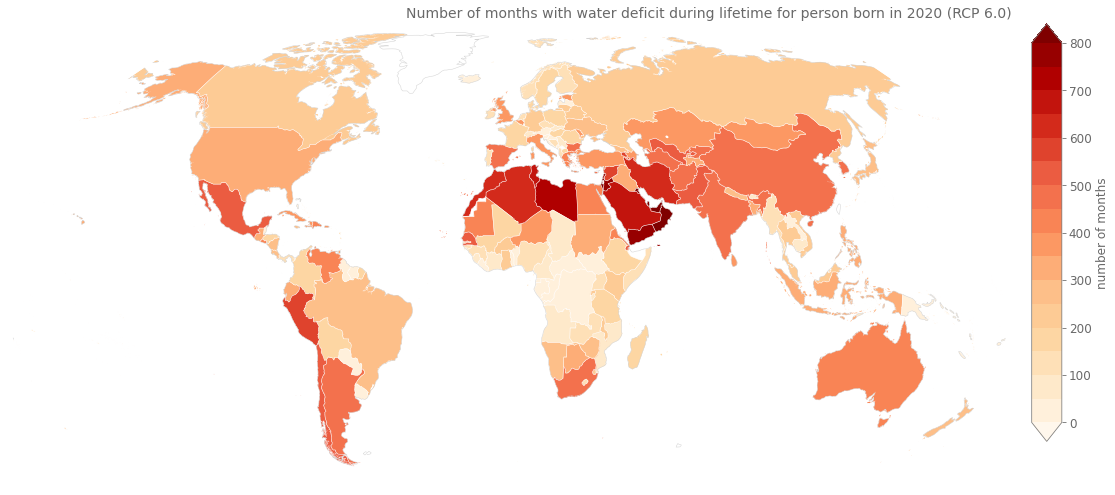

In [6]:
rcp = rcps[0]

variable = 'mmm_'+rcp
da = ds_frequency[variable]


# select birth years and merge with gpd countries
birth_year = 2020
bounds = np.arange(0,850,50)

legend_label = "number of months"
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()


gdf_exposure_birthyear = gdf_country_borders.merge(df_2, left_index=True, right_on='country')

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
gdf_exposure_birthyear.plot(ax=ax, column=variable, cax=cax, legend = True,  cmap='OrRd', legend_kwds={'label': legend_label}, transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('Number of months with water deficit during lifetime for person born in '+str(birth_year)+' ('+rcp_text[rcp]+')', loc='right'); 

/apps/brussel/RL8/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


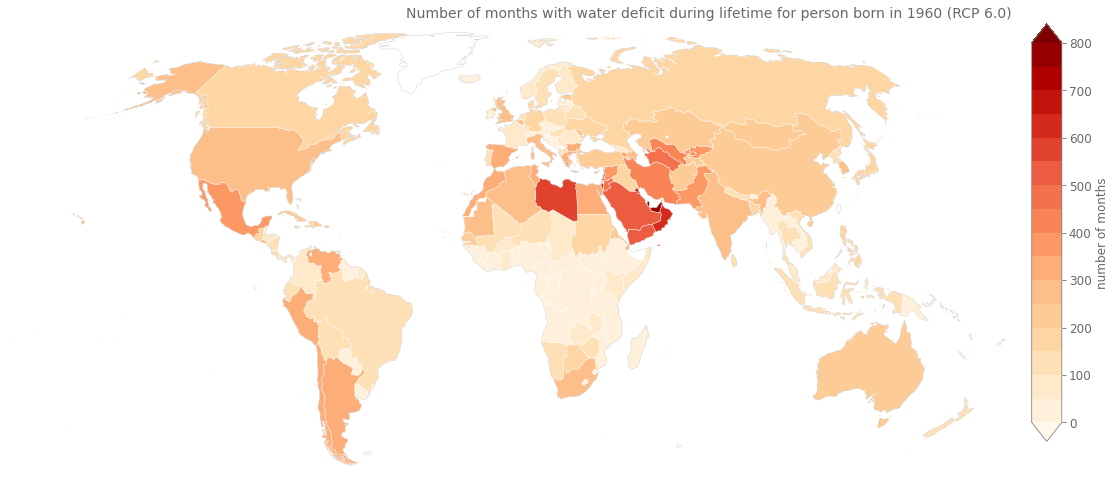

In [9]:
variable = 'mmm_'+rcp
da = ds_frequency[variable]


# select birth years and merge with gpd countries
birth_year = 1960
bounds = np.arange(0,850,50)

legend_label = "number of months"
df = da.sel({'birth_year' : birth_year}).to_dataframe()


gdf_exposure_birthyear = gdf_country_borders.merge(df, left_index=True, right_on='country')

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
gdf_exposure_birthyear.plot(ax=ax, column=variable, cax=cax, legend = True,  cmap='OrRd', legend_kwds={'label': legend_label}, vmax=100, transform=ccrs.PlateCarree(),  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('Number of months with water deficit during lifetime for person born in '+str(birth_year)+' ('+rcp_text[rcp]+')', loc='right'); 

/apps/brussel/RL8/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/apps/brussel/RL8/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


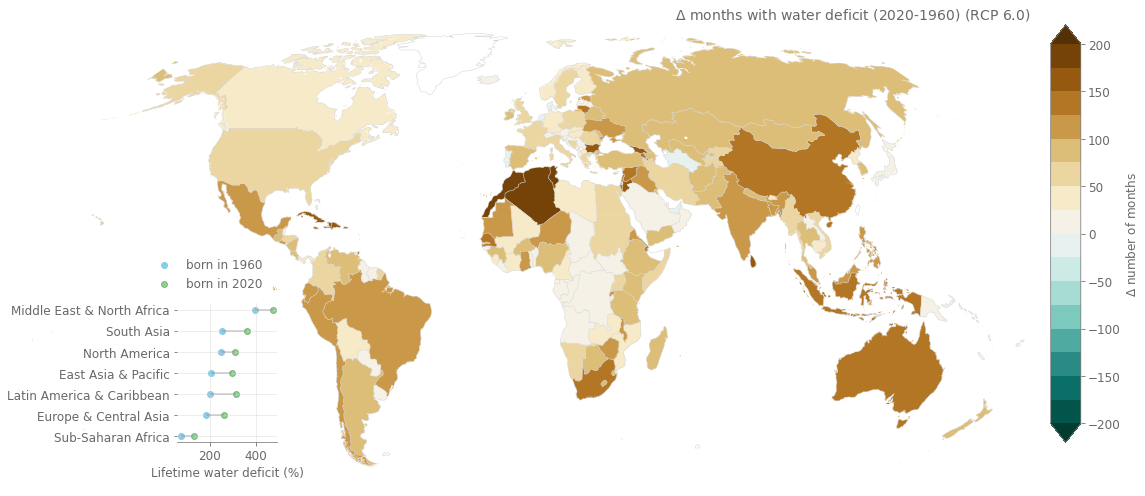

In [30]:
rcp = rcps[0]


variable = 'mmm_'+rcp
da = ds_frequency[variable]

# select birth years and merge with gpd countries
birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()



d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ number of months"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
bounds = np.arange(-300,350,50)
bounds = [-350,-300,-250,-200,-150,-100,-50,50,100,150,200,250,300,350]
bounds = np.arange(-200,225, 25)

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label},  transform=ccrs.PlateCarree(),  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ Average duration of water deficit event (2020-1960) '+rcp_text[rcp],  loc='right');
ax.set_title('$\Delta$ months with water deficit (2020-1960)'+' ('+rcp_text[rcp]+')', loc='right'); 


# ------------------------------------------------
# Panel d - inset lollipop plot

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_frequency_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_frequency_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

df = df_1960[df_1960["regions"].isin(regions['world'])].sort_values(by='1960',ascending=True) 

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions']); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('Lifetime water deficit (%)')
ax_inset.grid(color='lightgray', alpha=0.5)
#ax_inset.set_xlim((15,85));
#ax_inset.set_title(labels[3], loc='left'); 

/apps/brussel/RL8/broadwell/software/Cartopy/0.20.3-foss-2022a/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


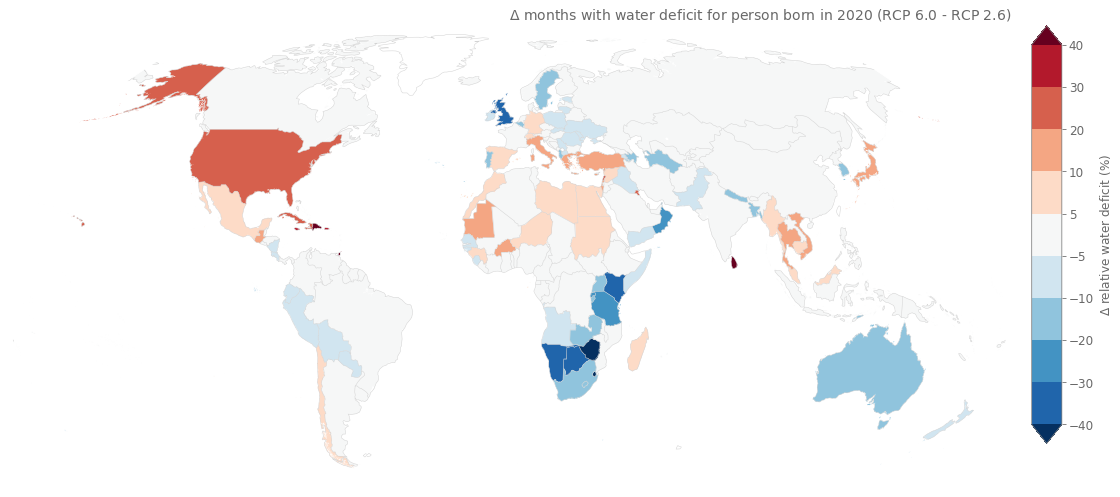

In [11]:
variable = 'delta_60_26'

d_waterdeficit_60= ds_frequency['mmm_'+rcps[0]].sel({'birth_year' : 2020}).to_dataframe()
d_waterdeficit_26= ds_frequency['mmm_'+rcps[1]].sel({'birth_year' : 2020}).to_dataframe()

d_waterdeficit_60_26 = (d_waterdeficit_60['mmm_'+rcps[0]] - d_waterdeficit_26['mmm_'+rcps[1]]).rename(variable)


legend_label = '$\Delta$ relative water deficit (%)'
gdf_emf = gdf_country_borders.merge(d_waterdeficit_60_26, left_index=True, right_on='country')
bounds = np.array([-40,-30,-20,-10,-5,5,10,20,30,40])
#bunds = np.arange(-50,60,10)


fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='RdBu_r',  cax=cax, legend_kwds={'label': legend_label}, transform=ccrs.PlateCarree(),  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ months with water deficit for person born in 2020 (RCP 6.0 - RCP 2.6)',  loc='right');

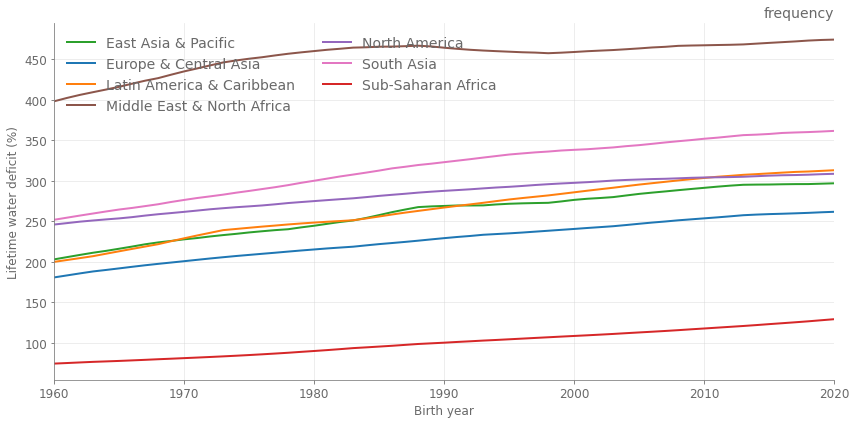

In [12]:
ds_pct_waterdeficit_perregion = ds_frequency_perregion
mode='frequency'
colors_toplot = {'world': {'Europe & Central Asia' : 'tab:blue', 'Latin America & Caribbean':'tab:orange','East Asia & Pacific': 'tab:green','South Asia': 'tab:pink','Sub-Saharan Africa'
                           :'tab:red','North America':'tab:purple',  'Middle East & North Africa': 'tab:brown'},
         'income' : {'Upper middle income': 'tab:blue','Lower middle income': 'tab:orange','High income' : 'tab:green','Low income':'tab:red'}}

flag_region = 'world'    
regions = {'world': ['East Asia & Pacific', 'Europe & Central Asia', 'Latin America & Caribbean', 'Middle East & North Africa', 'North America', 'South Asia', 'Sub-Saharan Africa'], 
           'income' :[  'Lower middle income','Low income', 'High income','Upper middle income',]}


# plot delta compared to 1960 birth cohort

fig = plt.figure(figsize=(12,6))

ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)


flag_uncertainty = ''# 'std' # std

var_type = ''#'delta_'

rcp = 'RCP60'
var = 'mmm_'+var_type+rcp


# sort regions based on values for 2020 birth year (for plotting uncertainty bar)
da_tosort = ds_pct_waterdeficit_perregion.sel(birth_year = 2020)[var]
regions_sorted = da_tosort.sortby(da_tosort, ascending=False)['region'].values
regions_toloop = [region for region in regions_sorted if region in regions[flag_region]]

for j, region in enumerate(regions[flag_region]):  


        ds_pct_waterdeficit_perregion.sel({'region':region})[var].plot(ax=ax, label=region, linewidth=2, color = colors_toplot[flag_region][region])

        # draw uncertainty rectangles

        # get values
        end_year = ds_pct_waterdeficit_perregion.birth_year.max()
        lqntl = ds_pct_waterdeficit_perregion.sel({'region':region})['lqntl_'+var_type+rcp].sel(birth_year = end_year).values
        uqntl = ds_pct_waterdeficit_perregion.sel({'region':region})['uqntl_'+var_type+rcp].sel(birth_year = end_year).values

        std = ds_pct_waterdeficit_perregion.sel({'region':region})['std_'+var_type+rcp].sel(birth_year = end_year).values
        mean = ds_pct_waterdeficit_perregion.sel({'region':region})['mmm_'+var_type+rcp].sel(birth_year = end_year).values

        if flag_uncertainty == 'std': 
            lower = mean - std 
            upper = mean + std                
        else: 
            lower = lqntl 
            upper = uqntl

        width = upper - lower

        # define width of the mean bar
        mean_width = 0.5
        offset = 0.5

        # quantile        


ax.legend(bbox_to_anchor=(1.52,0.5), loc='right',frameon=False)
ax.legend(loc='upper left',frameon=False, ncol=2, fontsize=14)

ax.set_title(mode, loc='right')
ax.set_title('', loc='center')
#ax.set_title(panellabels[i], loc='left')

ax.set_xlim((1960,2020))
#ax.set_ylim((0,100))

ax.set_xlabel('Birth year')
ax.set_ylabel('Lifetime water deficit (%)')
ax.grid(color='lightgray', alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)        

fig.tight_layout()

/rhea/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/maskplotting.py:165: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


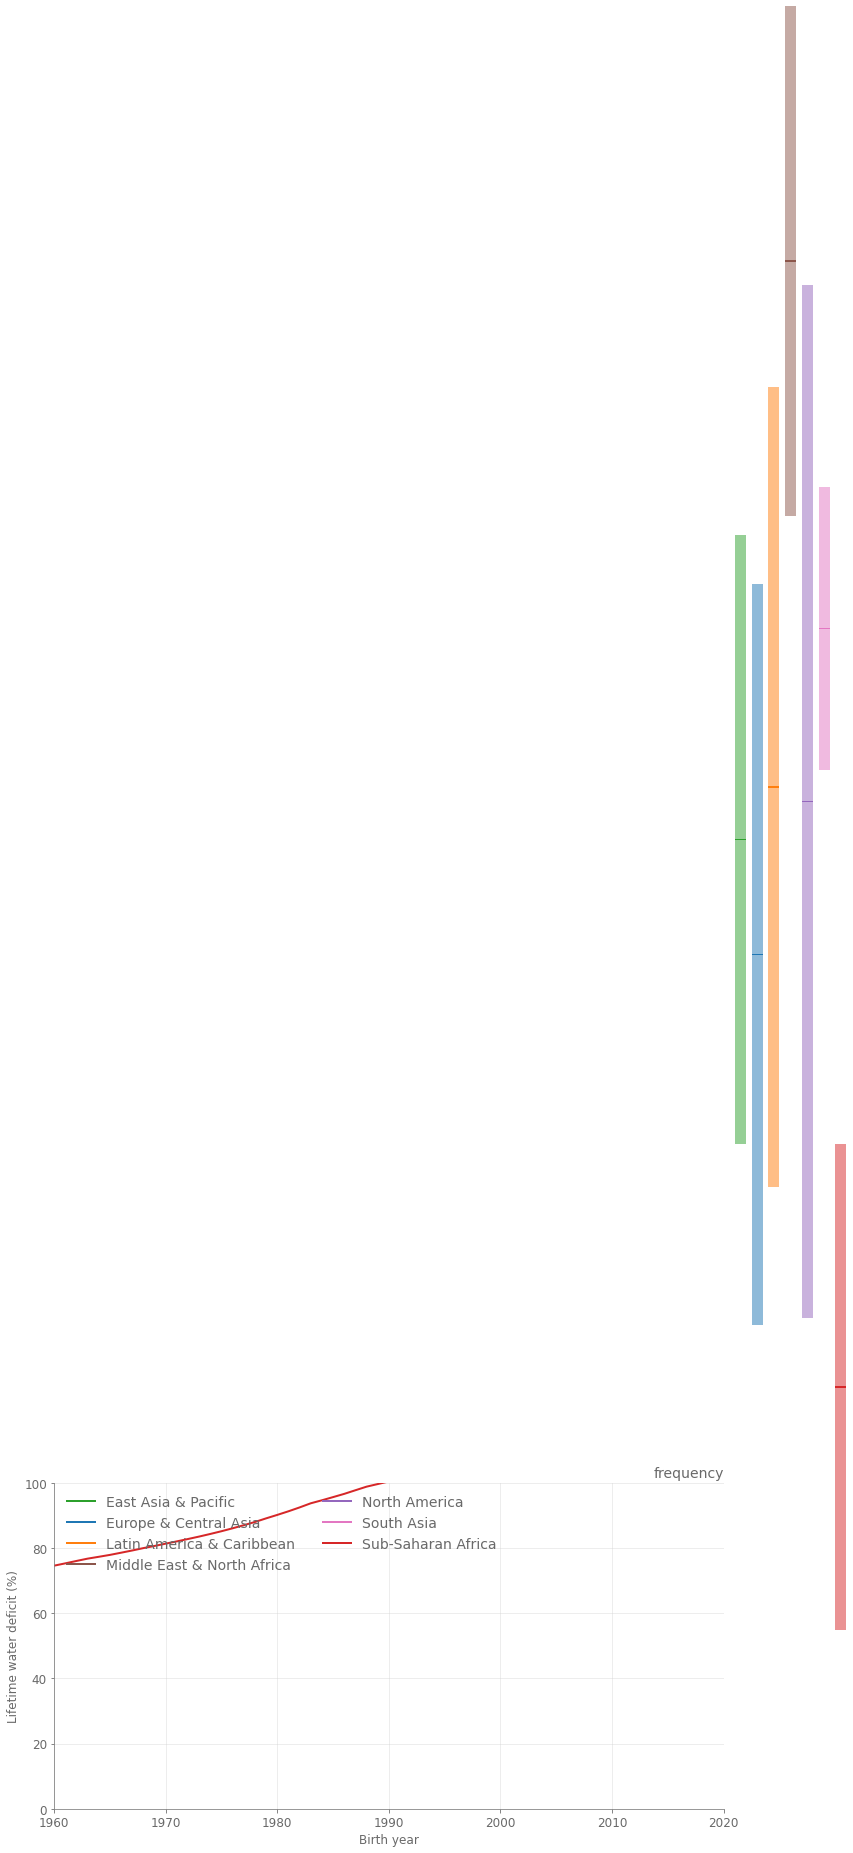

In [13]:
plot_lineplot(ds_frequency_perregion, flags['mode'])

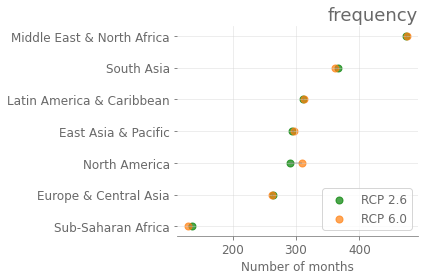

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
birth_year = 2020

ds_pct_waterdeficit_perregion = ds_frequency_perregion
mode=flags['mode']
df_rcp26 = ds_pct_waterdeficit_perregion[ 'mmm_RCP26'].sel(birth_year=birth_year).to_dataframe().drop(['birth_year'],axis=1)
values_rcp60 = ds_pct_waterdeficit_perregion[ 'mmm_RCP60'].sel(birth_year=birth_year).values

values = np.stack((df_rcp26.index.values,np.squeeze(df_rcp26.values),values_rcp60))
df = pd.DataFrame(values.T, columns=['regions','RCP26','RCP60'])

df = df[df["regions"].isin(regions[flag_region])]

regions_ordered = df.sort_values(by='RCP26',ascending=True)["regions"].values

df['regions_cat'] = pd.Categorical(df['regions'], categories=regions_ordered, ordered=True)
df = df.sort_values(by='regions_cat')

my_range=range(1,len(df.index)+1)


ax.hlines(y=my_range, xmin=df['RCP26'], xmax=df['RCP60'], color='grey', alpha=0.4)
ax.scatter(df['RCP26'], my_range, color='green', alpha=0.7, s=50, label='RCP 2.6')
ax.scatter(df['RCP60'], my_range, color='tab:orange', alpha=0.7 , s=50,label='RCP 6.0')
ax.legend(loc='lower right');

ax.set_yticks(my_range)
ax.set_yticklabels(df['regions']); 

ax.spines[['right', 'left', 'top']].set_visible(False)    

ax.set_xlabel('Number of months')
ax.set_title(mode, loc='right', fontsize=18);
ax.grid(color='lightgray', alpha=0.5)
#ax.set_xlim((15,85));

fig.tight_layout()